# Introduction and Prerequisites
This notebook serves as a tutorial on employing the ElasticNet model from QSAR package to a specific dataset. Before you start:
- Basic familiarity with Python, Pandas, and Scikit-learn will be beneficial.
- The main aim is to understand the flow and not just achieve a high score.

# Installation

In [12]:
# todo add installation instructions
# pip install qsarKit

# Table of Contents
1. Data Import
2. Cross-Validation
3. Model Without Optimization
4. Model With Hyperparameter Optimization
5. Model Evaluation
6. Prediction and Results

In [13]:
import warnings

warnings.filterwarnings('ignore')

from optuna.visualization import plot_optimization_history

from qsar.utils.visualizer import Visualizer
from qsar.utils.cross_validator import CrossValidator
from qsar.utils.extractor import Extractor
from qsar.utils.hyperparameter_optimizer import HyperParameterOptimizer

from qsar.models.elasticnet import ElasticnetModel

## 1. Data Import
Here, we'll load our dataset, explore it briefly, and prepare it for modeling.
Define paths for various datasets: full, neutral, and ionizable for both training and testing.
Initialize the extractor and split datasets into features (X) and target variable (y) based on "Log_MP_RATIO".
Also, retrieve the full training dataset.

In [14]:
data_paths = {
    "full_train": "../../data/full/train/full_train_unfiltered.csv",
    "full_test": "../../data/full/test/full_test_unfiltered.csv",
}

extractor = Extractor(data_paths)

x_dfs, y_dfs = extractor.split_x_y("Log_MP_RATIO")
df_full_tain = extractor.get_df("full_train")

## 2. Cross-validation
Initialize cross-validation and visualization tools.
Create cross-validation folds from the full training dataset and visualize the created folds.

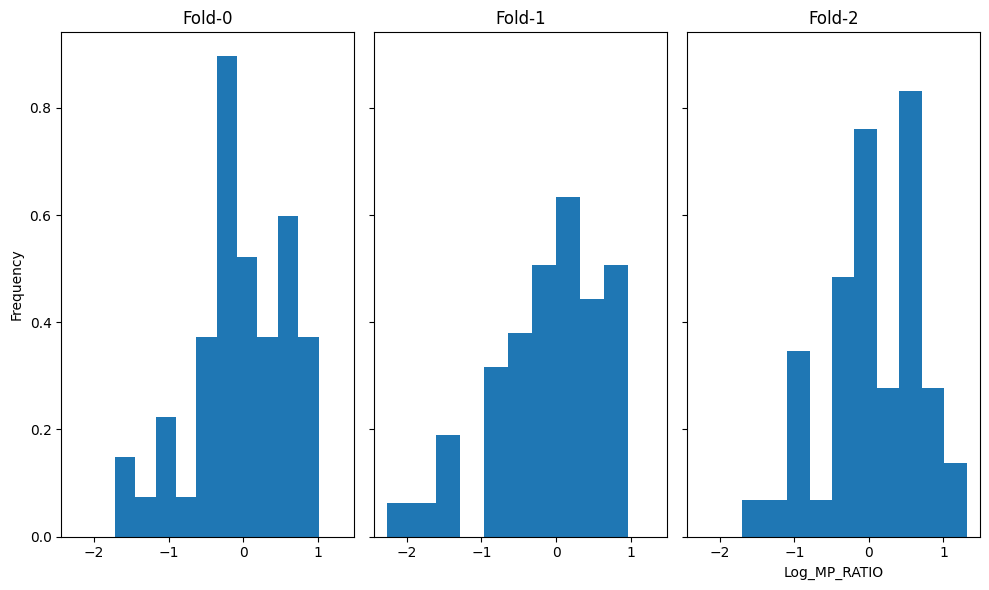

In [15]:
cross_validator = CrossValidator(df_full_tain)
visualizer = Visualizer()
X_list, y_list, df, y, n_folds = cross_validator.create_cv_folds()
visualizer.display_cv_folds(df, y, n_folds)

## 3. Model evaluation before hyperparameter optimization
Evaluate the performance of the ElasticNet model on the full training dataset and visualize its performance metrics.

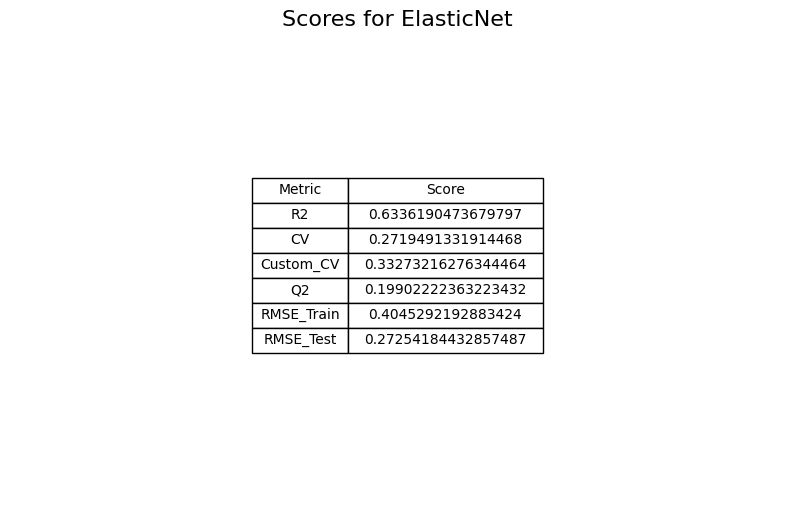

In [16]:
elasticnet_model = ElasticnetModel()
metrics = cross_validator.evaluate_model_performance(elasticnet_model.model,
                                                                   x_dfs["full_train"].copy(), y_dfs["full_train"].copy(),
                                                                   x_dfs["full_test"].copy(), y_dfs["full_test"].copy())
visualizer.display_model_performance("ElasticNet", metrics)

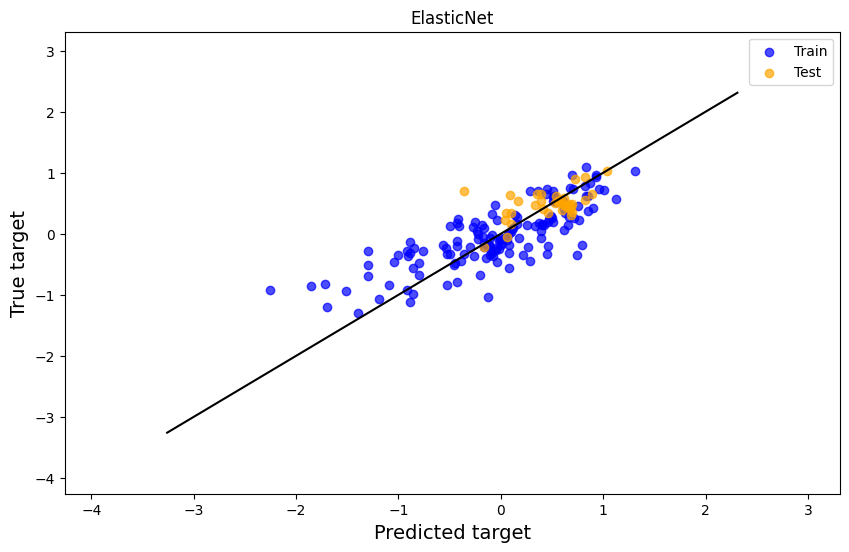

In [17]:
y_full_train_pred, y_full_test_pred = cross_validator.get_predictions(elasticnet_model.model, x_dfs["full_train"].copy(),
                                                                      y_dfs["full_train"].copy(), x_dfs["full_test"].copy())
visualizer.display_true_vs_predicted("ElasticNet", y_dfs["full_train"].copy(), y_dfs["full_test"].copy(), y_full_train_pred,
                                     y_full_test_pred)

## 4. Hyperparameter optimization
Initialize the ElasticnetModel, then use Optuna for hyperparameter optimization.
Print the best hyperparameters after optimization. Since the optimization is random and we put 100 trials to make it faster, the results may vary and be suboptimal.

In [18]:
elasticnet_model = ElasticnetModel()

optimizer = HyperParameterOptimizer(model=elasticnet_model, data=df_full_tain.copy(), direction='maximize', trials=100)

study = optimizer.optimize()
trial = study.best_trial
print(trial.value, trial.params)

[I 2024-03-30 00:49:53,221] A new study created in memory with name: no-name-f2040544-1ef8-4c2c-9888-5e2b6b8f6a47


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-30 00:50:54,396] Trial 2 finished with value: -1.0929141968375953 and parameters: {'alpha': 0.10321591038151824, 'l1_ratio': 0.06342839912783528}. Best is trial 2 with value: -1.0929141968375953.
[I 2024-03-30 00:50:54,846] Trial 7 finished with value: -1.0929141968375953 and parameters: {'alpha': 0.1172148909302016, 'l1_ratio': 0.17979274209803162}. Best is trial 2 with value: -1.0929141968375953.
[I 2024-03-30 00:50:54,885] Trial 3 finished with value: -1.0929141968375953 and parameters: {'alpha': 0.0008679757535152128, 'l1_ratio': 0.5994222913499541}. Best is trial 2 with value: -1.0929141968375953.
[I 2024-03-30 00:50:54,888] Trial 1 finished with value: -1.0929141968375953 and parameters: {'alpha': 0.0013680837838020647, 'l1_ratio': 0.3149279514542926}. Best is trial 2 with value: -1.0929141968375953.
[I 2024-03-30 00:50:54,928] Trial 0 finished with value: -1.0929141968375953 and parameters: {'alpha': 1.9972028372282917, 'l1_ratio': 0.8696018616740532}. Best is trial 2

## 5. Model evaluation after hyperparameter optimization
Evaluate the performance of the ElasticNet model with the best hyperparameters on the full training dataset.
Then visualize its performance metrics.

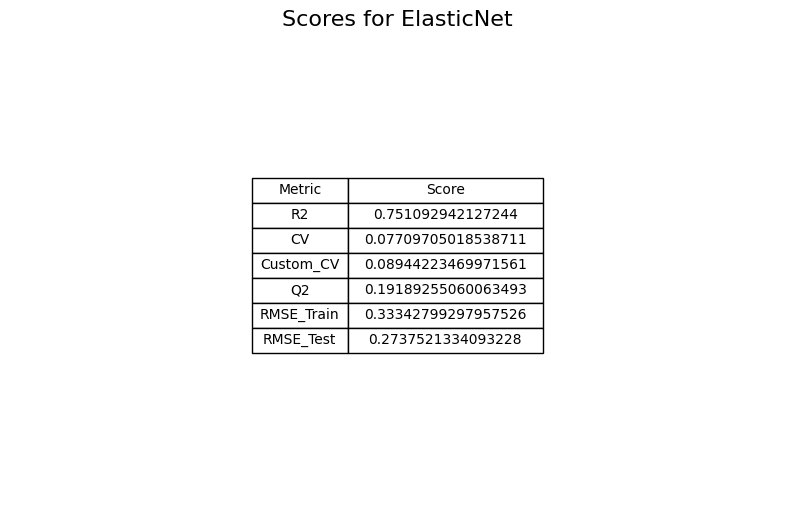

In [19]:
elasticnet_model.set_hyperparameters(**study.best_params)
metrics = cross_validator.evaluate_model_performance(
    elasticnet_model.model, x_dfs["full_train"].copy(), y_dfs["full_train"].copy(), x_dfs["full_test"].copy(), y_dfs["full_test"].copy())
visualizer.display_model_performance("ElasticNet", metrics)

Display the optimization history of the study (hyperparameter optimization).

In [20]:
display(plot_optimization_history(study))

## 6. Prediction and results
Predict with the optimized ElasticNet model and visualize the comparison between predicted and actual values.

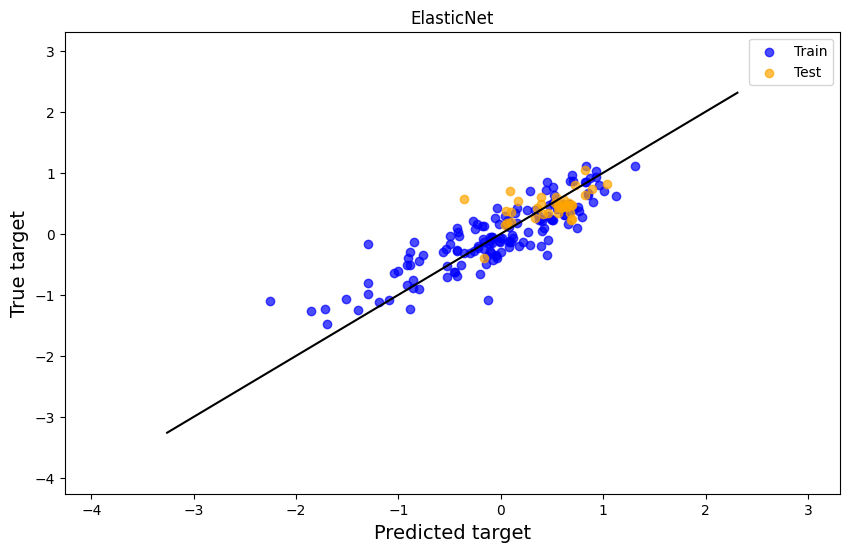

In [21]:
y_full_train_pred, y_full_test_pred = cross_validator.get_predictions(elasticnet_model.model, x_train=x_dfs["full_train"].copy(),
                                                                      y_train=y_dfs["full_train"].copy(), x_test=x_dfs["full_test"].copy())
visualizer.display_true_vs_predicted("ElasticNet", y_dfs["full_train"].copy(), y_dfs["full_test"].copy(), y_full_train_pred,
                                     y_full_test_pred)